In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- TASK 1: Data Acquisition & Analysis 
digits = load_digits()
X, y = digits.data, digits.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)




Shape of X: (1797, 64)
Shape of y: (1797,)


In [22]:
# Check for missing values 
print("Missing values in X:", np.isnan(X).sum())
print("Missing values in y:", np.isnan(y).sum())

# Statistical Analysis 
print("Feature means:", X.mean(axis=0)[:5])
print("Feature min:", X.min())
print("Feature max:", X.max())

Missing values in X: 0
Missing values in y: 0
Feature means: [ 0.          0.30383973  5.20478575 11.83583751 11.84808013]
Feature min: 0.0
Feature max: 16.0


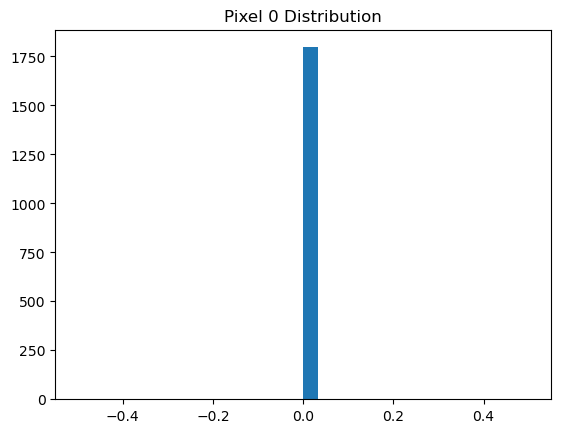

In [23]:
# Plots
plt.hist(X[:,0], bins=30)
plt.title("Pixel 0 Distribution")
plt.show()

In [24]:
# Scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Train/Test Split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=42
)

In [26]:
# --- TASK 2: Multiclass SVM from Scratch --- [cite: 56, 72]
class MulticlassSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):

        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # One weight vector per class
        self.W = np.zeros((n_classes, n_features))
        self.b = np.zeros(n_classes)

        # Train one-vs-rest classifiers
        for idx, c in enumerate(self.classes):

            # Convert labels to +1 / -1
            y_binary = np.where(y == c, 1, -1)

            w = np.zeros(n_features)
            b = 0

            # Gradient Descent
            for _ in range(self.n_iters):

                # Compute margins
                margins = y_binary * (X @ w + b)

                # Find misclassified points
                mask = margins < 1

                # Gradients
                if np.any(mask):

                    X_mis = X[mask]
                    y_mis = y_binary[mask]

                    dw = 2 * self.lambda_param * w - (X_mis.T @ y_mis) / len(y_mis)
                    db = -np.mean(y_mis)

                else:
                    # Only regularization term remains
                    dw = 2 * self.lambda_param * w
                    db = 0

                # Update
                w -= self.lr * dw
                b -= self.lr * db

            self.W[idx] = w
            self.b[idx] = b

    def predict(self, X):

        # Decision scores
        scores = X @ self.W.T + self.b

        # Choose class with max score
        return self.classes[np.argmax(scores, axis=1)]


In [27]:
# Hyperparameter Tuning

learning_rates = [0.0005, 0.001, 0.005]
lambdas = [0.001, 0.01, 0.1]
iterations = [500, 1000, 2000]

best_acc = 0
best_params = {}

print("Starting Hyperparameter Tuning...\n")

for lr in learning_rates:
    for lam in lambdas:
        for it in iterations:

            svm = MulticlassSVM(
                learning_rate=lr,
                lambda_param=lam,
                n_iters=it
            )

            svm.fit(X_train, y_train)
            preds = svm.predict(X_test)

            acc = accuracy_score(y_test, preds)

            print(f"LR={lr}, Lambda={lam}, Iters={it} → Acc={acc:.4f}")

            if acc > best_acc:
                best_acc = acc
                best_params = {
                    "learning_rate": lr,
                    "lambda": lam,
                    "iterations": it
                }


print("\nBest Accuracy:", best_acc)
print("Best Parameters:", best_params)


Starting Hyperparameter Tuning...



LR=0.0005, Lambda=0.001, Iters=500 → Acc=0.8685
LR=0.0005, Lambda=0.001, Iters=1000 → Acc=0.8704
LR=0.0005, Lambda=0.001, Iters=2000 → Acc=0.9037
LR=0.0005, Lambda=0.01, Iters=500 → Acc=0.8685
LR=0.0005, Lambda=0.01, Iters=1000 → Acc=0.8704
LR=0.0005, Lambda=0.01, Iters=2000 → Acc=0.9019
LR=0.0005, Lambda=0.1, Iters=500 → Acc=0.8685
LR=0.0005, Lambda=0.1, Iters=1000 → Acc=0.8667
LR=0.0005, Lambda=0.1, Iters=2000 → Acc=0.9074
LR=0.001, Lambda=0.001, Iters=500 → Acc=0.8704
LR=0.001, Lambda=0.001, Iters=1000 → Acc=0.9037
LR=0.001, Lambda=0.001, Iters=2000 → Acc=0.9444
LR=0.001, Lambda=0.01, Iters=500 → Acc=0.8704
LR=0.001, Lambda=0.01, Iters=1000 → Acc=0.9019
LR=0.001, Lambda=0.01, Iters=2000 → Acc=0.9444
LR=0.001, Lambda=0.1, Iters=500 → Acc=0.8667
LR=0.001, Lambda=0.1, Iters=1000 → Acc=0.9074
LR=0.001, Lambda=0.1, Iters=2000 → Acc=0.9407
LR=0.005, Lambda=0.001, Iters=500 → Acc=0.9500
LR=0.005, Lambda=0.001, Iters=1000 → Acc=0.9611
LR=0.005, Lambda=0.001, Iters=2000 → Acc=0.9611
LR=0.005

In [28]:
# Train Best Model (Train Final SVM With Best Parameters)

best_svm = MulticlassSVM(
    learning_rate=best_params["learning_rate"],
    lambda_param=best_params["lambda"],
    n_iters=best_params["iterations"]
)

best_svm.fit(X_train, y_train)

final_preds = best_svm.predict(X_test)

final_acc = accuracy_score(y_test, final_preds)

print("Final Test Accuracy:", final_acc)


Final Test Accuracy: 0.9611111111111111


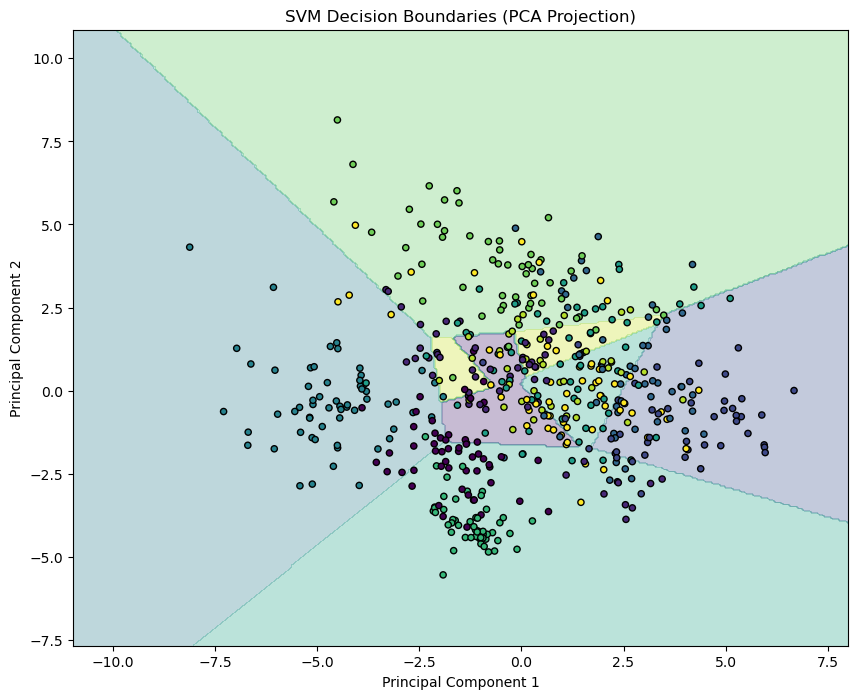

In [29]:
# PCA + Decision Boundary Plot

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y,
    test_size=0.3,
    random_state=42
)

# Train SVM on PCA data
svm_pca = MulticlassSVM(
    learning_rate=best_params["learning_rate"],
    lambda_param=best_params["lambda"],
    n_iters=best_params["iterations"]
)

svm_pca.fit(X_train_pca, y_train_pca)


# Create grid
x_min, x_max = X_pca[:,0].min()-1, X_pca[:,0].max()+1
y_min, y_max = X_pca[:,1].min()-1, X_pca[:,1].max()+1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]


# Predict grid
Z = svm_pca.predict(grid)
Z = Z.reshape(xx.shape)


# Plot
plt.figure(figsize=(10,8))

plt.contourf(xx, yy, Z, alpha=0.3)

plt.scatter(
    X_test_pca[:,0],
    X_test_pca[:,1],
    c=y_test_pca,
    s=20,
    edgecolors="k"
)

plt.title("SVM Decision Boundaries (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.show()
